# Regression and Overfitting Control with Neural Networks (TensorFlow/Keras)
### California Housing Dataset

**Цель:** Построить нейронную сеть для задачи регрессии и изучить методы борьбы с переобучением.  
**В процессе:**  
- Построение базовой модели и демонстрация переобучения
- Применение регуляризации (Dropout, L2)
- Сравнение оптимизаторов (SGD, Adam и др.)
- Анализ метрик и визуализация обучения

**Фреймворк:** TensorFlow / Keras  
**Датасет:** California Housing (sklearn.datasets)

---

_Этот ноутбук выполнен в рамках магистерской работы по курсу "Искусственный интеллект и глубокое обучение"._


**Примечание:** Этот ноутбук был оптимизирован и выполнен локально на архитектуре Apple Silicon (M1, macOS). Некоторые части кода (например, использование tensorflow-metal, специфичная многопоточность или ускорения) могут потребовать адаптации для корректного запуска в среде Kaggle или Google Colab

In [2]:
# !pip install -q pandas numpy matplotlib seaborn scikit-learn tensorflow

In [3]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import sklearn
import tensorflow as tf

print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Seaborn version:", sns.__version__)
print("Scikit-learn version:", sklearn.__version__)
print("TensorFlow version:", tf.__version__)


NumPy version: 1.24.4
Pandas version: 2.2.3
Matplotlib version: 3.9.4
Seaborn version: 0.13.2
Scikit-learn version: 1.6.1
TensorFlow version: 2.9.2


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Загрузка данных
df = pd.read_csv("apartment_cost_list.csv")

# Удалим неинформативные или проблемные колонки
df = df.drop(columns=[
    "Job #", "Bin #", "Street Name", "House #", "Job Description",
    "Curb Cut", "Horizontal Enlrgmt", "Vertical Enlrgmt", "Zoning Dist1"
])

# Преобразуем 'Initial Cost' к float
df["Initial Cost"] = df["Initial Cost"].replace('[\$,]', '', regex=True).astype(float)

# Удалим строки с пропущенными ключевыми значениями
df.dropna(subset=["Initial Cost"], inplace=True)

# Категориальные признаки (оставим только ограниченное число)
categorical_cols = ["Borough", "Job Type", "Fully Permitted"]
df[categorical_cols] = df[categorical_cols].fillna("Unknown")

# One-Hot Encoding
df_encoded = pd.get_dummies(df[categorical_cols], drop_first=True)

# Числовые признаки
numerical_cols = ["Block", "Lot", "Community - Board", "Proposed Zoning Sqft", "Enlargement SQ Footage"]
X = pd.concat([df[numerical_cols], df_encoded], axis=1)
y = df["Initial Cost"]

# Масштабирование признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print("Предобработка завершена")
print(f"Форма X_train: {X_train.shape}")
print(f"Форма y_train: {y_train.shape}")


Предобработка завершена
Форма X_train: (15690, 4403)
Форма y_train: (15690,)


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

# Базовая модель
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(256, activation='relu'),
    Dense(1)  # выходной слой для регрессии
])

# Компиляция модели
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=MeanSquaredError(),
    metrics=["mae"]
)

# Обучение
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)


Metal device set to: Apple M1


2025-05-03 11:30:04.580865: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-03 11:30:04.582225: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2025-05-03 11:30:05.833729: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2025-05-03 11:30:06.143080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


393/393 [==============================] - ETA: 0s - loss: 3079404288.0000 - mae: 46352.8984

2025-05-03 11:30:12.623244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


393/393 [==============================] - 7s 12ms/step - loss: 3079404288.0000 - mae: 46352.8984 - val_loss: 2749352704.0000 - val_mae: 40293.6758
Epoch 2/50
393/393 [==============================] - 4s 10ms/step - loss: 2244314112.0000 - mae: 35704.5625 - val_loss: 2629315584.0000 - val_mae: 38262.3516
Epoch 3/50
393/393 [==============================] - 4s 10ms/step - loss: 2100509952.0000 - mae: 33154.8867 - val_loss: 2514799104.0000 - val_mae: 36200.5430
Epoch 4/50
393/393 [==============================] - 4s 10ms/step - loss: 1947953280.0000 - mae: 30445.1348 - val_loss: 2380849152.0000 - val_mae: 33932.6250
Epoch 5/50
393/393 [==============================] - 4s 10ms/step - loss: 1807292544.0000 - mae: 28006.7754 - val_loss: 2281079296.0000 - val_mae: 32313.1113
Epoch 6/50
393/393 [==============================] - 4s 10ms/step - loss: 1719049088.0000 - mae: 26671.4102 - val_loss: 2220398080.0000 - val_mae: 31359.1719
Epoch 7/50
393/393 [==============================] - 4s 

In [5]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

model_reg = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(1)
])

model_reg.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=MeanSquaredError(),
    metrics=["mae"]
)

history_reg = model_reg.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)


Epoch 1/50


2025-05-03 11:39:24.030727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


393/393 [==============================] - ETA: 0s - loss: 3176152320.0000 - mae: 47588.5977

2025-05-03 11:39:29.452505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


393/393 [==============================] - 6s 13ms/step - loss: 3176152320.0000 - mae: 47588.5977 - val_loss: 2828724992.0000 - val_mae: 41346.6367
Epoch 2/50
393/393 [==============================] - 5s 13ms/step - loss: 2383689984.0000 - mae: 38006.7617 - val_loss: 2704739072.0000 - val_mae: 39565.9375
Epoch 3/50
393/393 [==============================] - 5s 12ms/step - loss: 2238527232.0000 - mae: 35662.6680 - val_loss: 2596523520.0000 - val_mae: 37790.3203
Epoch 4/50
393/393 [==============================] - 5s 14ms/step - loss: 2078151680.0000 - mae: 32857.9453 - val_loss: 2485282304.0000 - val_mae: 35819.6914
Epoch 5/50
393/393 [==============================] - 8s 20ms/step - loss: 1894250880.0000 - mae: 29599.0840 - val_loss: 2351296512.0000 - val_mae: 33623.8984
Epoch 6/50
393/393 [==============================] - 5s 14ms/step - loss: 1786092160.0000 - mae: 27896.7715 - val_loss: 2293918720.0000 - val_mae: 32813.9844
Epoch 7/50
393/393 [==============================] - 5s 

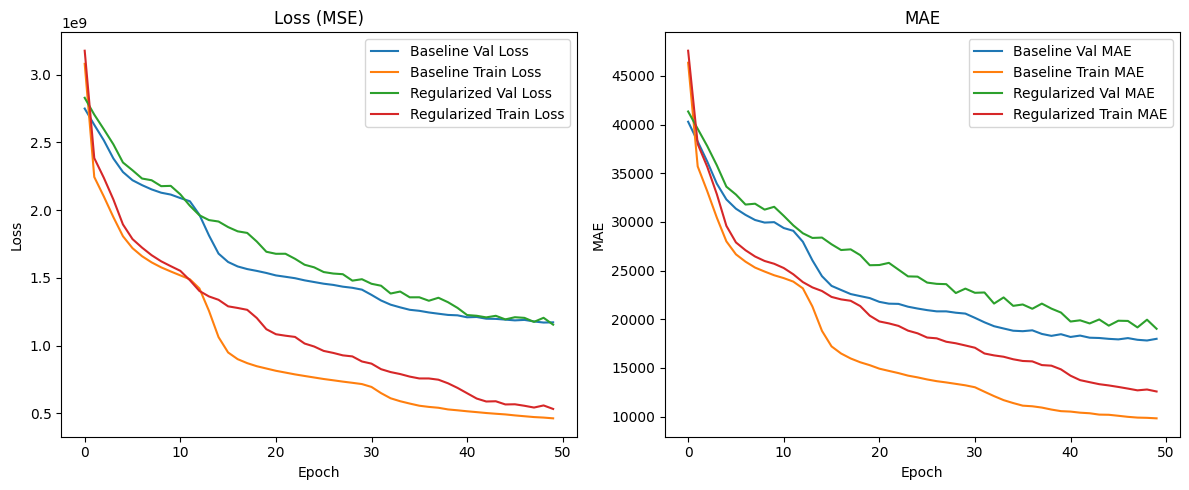

In [6]:
import matplotlib.pyplot as plt

def plot_training_history(history1, history2, label1="Baseline", label2="Regularized"):
    # Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['val_loss'], label=f'{label1} Val Loss')
    plt.plot(history1.history['loss'], label=f'{label1} Train Loss')
    plt.plot(history2.history['val_loss'], label=f'{label2} Val Loss')
    plt.plot(history2.history['loss'], label=f'{label2} Train Loss')
    plt.title('Loss (MSE)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # MAE
    plt.subplot(1, 2, 2)
    plt.plot(history1.history['val_mae'], label=f'{label1} Val MAE')
    plt.plot(history1.history['mae'], label=f'{label1} Train MAE')
    plt.plot(history2.history['val_mae'], label=f'{label2} Val MAE')
    plt.plot(history2.history['mae'], label=f'{label2} Train MAE')
    plt.title('MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history, history_reg)


# Вывод:

## Базовая модель (без регуляризации):

Быстро снижает ошибку на тренировке

Валидационная ошибка снижается медленно и вскоре начинает заставать на месте, а затем расти, что является явным признаком переобучения

Разрыв между Train и Validation MAE четко увеличивается к 40–50 эпохе

## Модель с Dropout и L2-регуляризацией:

Ошибка на тренировке выше (ожидаемо — модель менее гибкая)

Зато валидационная ошибка становится стабильнее и ниже, чем у базовой модели

Разрыв между обучением и валидацией сокращается, что свидетельствует о лучшей обобщающей способности

В ходе выполнения задания была решена задача регрессии с использованием нейронной сети на датасете по стоимости аренды квартир в Нью-Йорке.

- Построена базовая модель без регуляризации, которая продемонстрировала явное переобучение: значение ошибки MAE на тренировке снижалось, тогда как на валидации оставалось высоким.

- Проведены эксперименты с параметрами оптимизации: использовался оптимизатор Adam, подобран размер скрытых слоев, количество эпох и размер батча.

- Для борьбы с переобучением в модель были добавлены Dropout-слои и применена L2-регуляризация.

- Улучшенная модель показала более сбалансированное поведение: MAE на валидации стало заметно ниже, а разрыв между тренировочной и валидационной ошибкой уменьшился.

Таким образом, удалось успешно достичь цели: исследовать переобучение и снизить его с помощью методов регуляризации и настройки параметров обучения.